# Interpreting Models

As machine learning becomes more and more and more prevelant, the predictions made by models have greater influence over many aspects of our society. For example, machine learning models are an increasingly significant factor in how banks decide to grant loans or doctors prioritise treatments. The ability to interpret and explain models is increasingly important, so that the rationale for the predictions made by machine learning models can be explained and justified, and any inadvertant bias in the model can be identified.

## Explaining a Model
You can use Azure Machine Learning to interpret a model by using an *explainer* that quantifies the amount of influence each feature contribues to the predicted label. There are may common explainers, each suitable for different kinds of modeling algorithm; but the basic approach to usng them is the same.

Let's start with a model that is trained outside of Azure Machine Learning - we'll go ahead and train a simple binary classification model that predicts the likelihood of a patient being diabetic.

In [10]:
#  !pip install --upgrade azureml-sdk[notebooks]  # Use to install but beware, it takes awhile.

import azureml.core
print("Ready to use Azure ML", azureml.core.VERSION)

Ready to use Azure ML 1.0.76


Loading Data...
Training a logistic regression model with regularization rate of 0.1
Accuracy: 0.7893333333333333
AUC: 0.8568708132447238


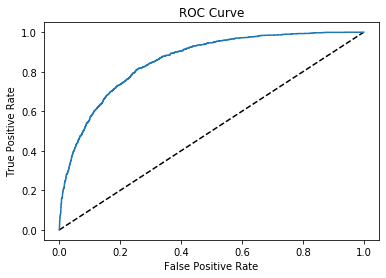

In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

# Set regularization rate hyperparameter value
reg = 0.1

# load the diabetes data
print("Loading Data...")
data = pd.read_csv('data/diabetes.csv')

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
labels = ['not-diabetic', 'diabetic']

# Separate features and labels
X, y = data[features].values, data['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))

# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
fig = plt.figure(figsize=(6, 4))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Our training process generated some model evaluation meytrics based on a hold-back validation dataset, so we have an idea of how accurately it predicts; but how do the features in the data influence the prediction?

### Install the Azure ML Interpretability Library
To find out, we'll first install the Azure ML Interpretability library. You can use this to interpret many typical kinds of model, even if they haven't been trained in an Azure ML experiment or registered in an Azure ML workspace.

In [12]:
!pip install azureml-interpret

In [13]:
print('Done')

Done


### Get an Explainer for our Model

Noe that we have the library installed, let's get a suitable explainer for our model. There are many kinds of explainer. In this example we'll use a *Mimic Explainer*, which is a "black box" explainer that can be used to explain many kidns of model. We'll specifically use to explain a model that's been trained using a linear algorithm - such as our logistic regression model.

In [14]:
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import LinearExplainableModel

# "features" and "classes" fields are optional
explainer = MimicExplainer(model, 
                           X_train, 
                           LinearExplainableModel, 
                           augment_data=True, 
                           max_num_of_augmentations=10, 
                           features=features, 
                           classes=labels)

print(explainer, "ready!")

MimicExplainer ready!


### Get Global Feature Importance

The first thing we'll do is try to explain the model by evaluating the overall *feature importance* - in other words, quantifying the extent to which each feature influences the prediction based on the whole training dataset.

In [15]:
# you can use the training data or the test data here
global_explanation = explainer.explain_global(X_train)

# Get the top features by importance
global_feature_importance = global_explanation.get_feature_importance_dict()
for feature, importance in global_feature_importance.items():
    print(feature,":", importance)


Pregnancies : 0.7912461329612774
Age : 0.5578915833215818
BMI : 0.4348479763205777
SerumInsulin : 0.37651166271541786
DiabetesPedigree : 0.2916807538785718
TricepsThickness : 0.2805591638989587
PlasmaGlucose : 0.24405291869406956
DiastolicBloodPressure : 0.16182233921093817


(you can ignore any warnings that are displayed)

The feature importance is ranked, with the most important feature listed first.

### Get Local Feature Importance

So we have an overall view, but what about explaining individual observations? Let's generate *local* explanations for individual predictions, quantifying the extent to which each feature influenced the decision to predict each of the possible label values. In this case, it's a binary model, so there are two possible labels (non-diabetic and diabetic); and we can quantify the influence of each feature for each of these label values for each observation in a given dataset - we'll just evaluate the first three cases in the test dataset.

In [16]:
# explain the first three observations in the test set
local_explanation = explainer.explain_local(X_test[0:3])

# Get features and importance for positive and negative influence
local_features = local_explanation.get_ranked_local_names()
local_importance = local_explanation.get_ranked_local_values()

for l in range(len(local_features)):
    print('Support for', labels[l])
    label = local_features[l]
    for o in range(len(label)):
        print("\tObservation", o + 1)
        feature_list = label[o]
        for f in range(len(feature_list)):
            print("\t\t", feature_list[f], ':', local_importance[l][o][f])

Support for not-diabetic
	Observation 1
		 Pregnancies : 0.5979521939874871
		 PlasmaGlucose : 0.4892167575289769
		 Age : 0.2342695031929723
		 DiabetesPedigree : 0.1771040687818941
		 SerumInsulin : -0.11432232534115147
		 DiastolicBloodPressure : -0.24231392534136842
		 BMI : -0.2833231594814085
		 TricepsThickness : -0.3613938496871715
	Observation 2
		 Pregnancies : 0.8690093988775538
		 BMI : 0.5696128016251233
		 Age : 0.5228667511839393
		 TricepsThickness : 0.39849874524709933
		 DiabetesPedigree : 0.2977933513642537
		 PlasmaGlucose : -0.11428403959482601
		 DiastolicBloodPressure : -0.13099880915730122
		 SerumInsulin : -0.16244698197395818
	Observation 3
		 Age : 0.5228667511839393
		 Pregnancies : 0.32689498909742043
		 BMI : 0.09350799763118306
		 DiastolicBloodPressure : 0.05823688835561303
		 TricepsThickness : 0.040902229983913053
		 DiabetesPedigree : -0.10040194322748265
		 PlasmaGlucose : -0.11428403959482601
		 SerumInsulin : -0.3845607818176815
Support for diabeti